In [1]:
import re
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
def select_gpu(N):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpus[N], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)    

In [3]:
select_gpu(0)
epochs = 1024
batch_size = 1024
model_name = 'bert-chinese'
embedding_path = '/home/Danny/pretrain_model/{}'.format(model_name)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
3 Physical GPUs, 1 Logical GPUs


In [1]:
# 不用儲存article_id, 轉成list
def training_txt_to_list(path):
    with open(path, 'r') as f:
        txt = str(f.read())
    txt_list = txt.split('\n')
    text_label_list = list()
    tmp = list()
    for line in txt_list:
        if line == '--------------------':
            text_label_list.append(tmp)
            tmp = list()
            continue
        if line == '':
            continue
        tmp.append(line)
    x = list()
    y = list()
    for text_label in text_label_list:
        text = text_label[0]
        label = text_label[2:]
        label_list = ['O' for i in range(len(text))]
        for i in label:
            entity = i.split('\t')
            if int(entity[1]) > int(entity[2]):
                continue
            b = int(entity[1])
            label_list[b] = 'B-{}'.format(entity[-1])
            for j in range(int(entity[1])+1, int(entity[2])):
                label_list[j] = 'I-{}'.format(entity[-1])
        for i, j in enumerate(text):
            if j == '，' or j == '。' or j == '？':
                label_list[i] = j
                
        text_list = re.split('\uff0c|\u3002|\uff1f', text)
        for sentence in text_list:
            x.append([i for i in sentence])
        x = x[:-1]
            
        sentence = list()
        for i in label_list:
            if i == '，' or i == '。' or i == '？':
                y.append(sentence)
                sentence = list()
            else:
                sentence.append(i)
                
    return [x, y]

In [5]:
x1, y1 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage1/SampleData_deid.txt')

In [6]:
x2, y2 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage2/train_1_update.txt')

In [7]:
x4, y4 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage4/train_2.txt')

In [8]:
x = x4
y = y4
print(len(x))
print(len(y))

76162
76162


In [9]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))
print(len(test_x), len(test_y))

48743 48743
12186 12186
15233 15233


In [10]:
%%time
import kashgari
from kashgari.tasks.labeling import BiLSTM_CRF_Model
from kashgari.embeddings import BertEmbedding
kashgari.config.use_cudnn_cell = True
bert_embedding = BertEmbedding(embedding_path, 
                           sequence_length='auto',
                           trainable=True,
                           task='kashgari.LABELING', 
                          )
model = BiLSTM_CRF_Model(bert_embedding)
history = model.fit(train_x,
                    train_y,
                    valid_x,
                    valid_y,
                    epochs=epochs,
                    batch_size=batch_size,
                   )

2020-12-14 22:43:33,133 [DEBUG] kashgari - ------------------------------------------------
2020-12-14 22:43:33,134 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-14 22:43:33,134 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/bert-chinese/bert_config.json
2020-12-14 22:43:33,135 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/bert-chinese/vocab.txt
2020-12-14 22:43:33,135 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/bert-chinese/bert_model.ckpt
2020-12-14 22:43:33,135 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[

Epoch 1/1024
47/47 [==============================] - 37s 795ms/step - loss: 1.6411 - accuracy: 0.9289 - val_loss: 21.7794 - val_accuracy: 0.9742
Epoch 2/1024
47/47 [==============================] - 33s 695ms/step - loss: 0.4392 - accuracy: 0.9784 - val_loss: 21.6170 - val_accuracy: 0.9814
Epoch 3/1024
47/47 [==============================] - 33s 694ms/step - loss: 0.3233 - accuracy: 0.9821 - val_loss: 21.5689 - val_accuracy: 0.9840
Epoch 4/1024
47/47 [==============================] - 33s 695ms/step - loss: 0.2538 - accuracy: 0.9841 - val_loss: 21.4615 - val_accuracy: 0.9865
Epoch 5/1024
47/47 [==============================] - 33s 692ms/step - loss: 0.2156 - accuracy: 0.9858 - val_loss: 21.4409 - val_accuracy: 0.9882
Epoch 6/1024
47/47 [==============================] - 33s 696ms/step - loss: 0.1887 - accuracy: 0.9873 - val_loss: 21.3580 - val_accuracy: 0.9894
Epoch 7/1024
47/47 [==============================] - 33s 694ms/step - loss: 0.1715 - accuracy: 0.9882 - val_loss: 21.2900 -

Epoch 57/1024
47/47 [==============================] - 33s 696ms/step - loss: 0.0158 - accuracy: 0.9986 - val_loss: 19.9554 - val_accuracy: 0.9934
Epoch 58/1024
47/47 [==============================] - 33s 696ms/step - loss: 0.0149 - accuracy: 0.9987 - val_loss: 19.9552 - val_accuracy: 0.9934
Epoch 59/1024
47/47 [==============================] - 33s 697ms/step - loss: 0.0152 - accuracy: 0.9986 - val_loss: 19.9001 - val_accuracy: 0.9931
Epoch 60/1024
47/47 [==============================] - 33s 696ms/step - loss: 0.0156 - accuracy: 0.9986 - val_loss: 19.8902 - val_accuracy: 0.9936
Epoch 61/1024
47/47 [==============================] - 33s 696ms/step - loss: 0.0146 - accuracy: 0.9987 - val_loss: 19.9307 - val_accuracy: 0.9936
Epoch 62/1024
47/47 [==============================] - 33s 696ms/step - loss: 0.0139 - accuracy: 0.9987 - val_loss: 19.8590 - val_accuracy: 0.9924
Epoch 63/1024
47/47 [==============================] - 33s 695ms/step - loss: 0.0144 - accuracy: 0.9988 - val_loss: 19

47/47 [==============================] - 32s 690ms/step - loss: 0.0060 - accuracy: 0.9992 - val_loss: 17.7827 - val_accuracy: 0.9664
Epoch 168/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0050 - accuracy: 0.9993 - val_loss: 17.7628 - val_accuracy: 0.9657
Epoch 169/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0056 - accuracy: 0.9993 - val_loss: 17.7391 - val_accuracy: 0.9652
Epoch 170/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0055 - accuracy: 0.9992 - val_loss: 17.7032 - val_accuracy: 0.9646
Epoch 171/1024
47/47 [==============================] - 32s 689ms/step - loss: 0.0059 - accuracy: 0.9991 - val_loss: 17.7242 - val_accuracy: 0.9621
Epoch 172/1024
47/47 [==============================] - 32s 691ms/step - loss: 0.0052 - accuracy: 0.9993 - val_loss: 17.6356 - val_accuracy: 0.9631
Epoch 173/1024
47/47 [==============================] - 32s 691ms/step - loss: 0.0053 - accuracy: 0.9993 - val_loss: 17.5981 - 

47/47 [==============================] - 32s 690ms/step - loss: 0.0042 - accuracy: 0.9992 - val_loss: 15.5646 - val_accuracy: 0.0305
Epoch 278/1024
47/47 [==============================] - 32s 689ms/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 15.5583 - val_accuracy: 0.0308
Epoch 279/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0045 - accuracy: 0.9992 - val_loss: 15.4623 - val_accuracy: 0.0296
Epoch 280/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0040 - accuracy: 0.9994 - val_loss: 15.4493 - val_accuracy: 0.0251
Epoch 281/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0036 - accuracy: 0.9993 - val_loss: 15.4104 - val_accuracy: 0.0263
Epoch 282/1024
47/47 [==============================] - 32s 689ms/step - loss: 0.0039 - accuracy: 0.9993 - val_loss: 15.4466 - val_accuracy: 0.0280
Epoch 283/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0037 - accuracy: 0.9993 - val_loss: 15.4018 - 

47/47 [==============================] - 32s 691ms/step - loss: 0.0031 - accuracy: 0.9995 - val_loss: 14.1975 - val_accuracy: 0.0076
Epoch 388/1024
47/47 [==============================] - 32s 688ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 14.1827 - val_accuracy: 0.0069
Epoch 389/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 14.1369 - val_accuracy: 0.0072
Epoch 390/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 14.1672 - val_accuracy: 0.0067
Epoch 391/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0036 - accuracy: 0.9993 - val_loss: 14.1466 - val_accuracy: 0.0071
Epoch 392/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 14.1376 - val_accuracy: 0.0069
Epoch 393/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0044 - accuracy: 0.9993 - val_loss: 14.1349 - 

47/47 [==============================] - 32s 691ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 13.6158 - val_accuracy: 0.0023
Epoch 498/1024
47/47 [==============================] - 32s 689ms/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 13.6006 - val_accuracy: 0.0025
Epoch 499/1024
47/47 [==============================] - 32s 689ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 13.5911 - val_accuracy: 0.0026
Epoch 500/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 13.6032 - val_accuracy: 0.0024
Epoch 501/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 13.5961 - val_accuracy: 0.0022
Epoch 502/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 13.5967 - val_accuracy: 0.0022
Epoch 503/1024
47/47 [==============================] - 32s 689ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 13.6072 - 

47/47 [==============================] - 32s 691ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 13.4225 - val_accuracy: 0.0020
Epoch 608/1024
47/47 [==============================] - 32s 691ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 13.3948 - val_accuracy: 0.0021
Epoch 609/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0029 - accuracy: 0.9995 - val_loss: 13.4230 - val_accuracy: 0.0020
Epoch 610/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 13.4011 - val_accuracy: 0.0023
Epoch 611/1024
47/47 [==============================] - 32s 689ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 13.4040 - val_accuracy: 0.0023
Epoch 612/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 13.4111 - val_accuracy: 0.0022
Epoch 613/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 13.4000 - 

47/47 [==============================] - 32s 690ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 13.2182 - val_accuracy: 0.0011
Epoch 718/1024
47/47 [==============================] - 32s 691ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 13.2475 - val_accuracy: 0.0011
Epoch 719/1024
47/47 [==============================] - 32s 691ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 13.2425 - val_accuracy: 0.0012
Epoch 720/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 13.2430 - val_accuracy: 0.0012
Epoch 721/1024
47/47 [==============================] - 33s 695ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 13.2734 - val_accuracy: 0.0012
Epoch 722/1024
47/47 [==============================] - 33s 694ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 13.2522 - val_accuracy: 0.0013
Epoch 723/1024
47/47 [==============================] - 32s 691ms/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 13.2584 - 

47/47 [==============================] - 32s 690ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 13.1852 - val_accuracy: 0.0010
Epoch 828/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 13.2157 - val_accuracy: 0.0012
Epoch 829/1024
47/47 [==============================] - 33s 699ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 13.1725 - val_accuracy: 0.0011
Epoch 830/1024
47/47 [==============================] - 32s 691ms/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 13.1729 - val_accuracy: 0.0011
Epoch 831/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 13.1911 - val_accuracy: 0.0011
Epoch 832/1024
47/47 [==============================] - 32s 691ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 13.1924 - val_accuracy: 0.0010
Epoch 833/1024
47/47 [==============================] - 32s 691ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 13.1719 - 

47/47 [==============================] - 32s 690ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 13.1336 - val_accuracy: 9.4864e-04
Epoch 937/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 13.1397 - val_accuracy: 9.0350e-04
Epoch 938/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 13.1505 - val_accuracy: 9.7178e-04
Epoch 939/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 13.1398 - val_accuracy: 9.2078e-04
Epoch 940/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 13.1808 - val_accuracy: 9.8699e-04
Epoch 941/1024
47/47 [==============================] - 32s 690ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 13.1644 - val_accuracy: 9.5338e-04
Epoch 942/1024
47/47 [==============================] - 32s 689ms/step - loss: 0.0026 - accuracy: 0.999

In [11]:
model.evaluate(test_x, test_y)
model_path = 'model/{}_epoch_{}_batch_{}'.format(model_name, epochs, batch_size)
model.save(model_path)

2020-12-15 08:08:02,335 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 65
2020-12-15 08:08:02,445 [DEBUG] kashgari - predict seq_length: None, input: (2, 15233, 65)


477/477 [==============================] - 42s 88ms/step


2020-12-15 08:08:49,066 [DEBUG] kashgari - predict output: (15233, 65)
2020-12-15 08:08:49,067 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]



                precision    recall  f1-score   support

          time     0.8339    0.8292    0.8315       878
      med_exam     0.9453    0.9030    0.9237       134
          name     0.9756    0.9091    0.9412        88
      location     0.9381    0.8922    0.9146       102
         money     0.9268    0.8837    0.9048        43
    profession     0.8750    0.4118    0.5600        17
       contact     0.8462    0.6111    0.7097        18
            ID     1.0000    0.4444    0.6154         9
        family     1.0000    0.6364    0.7778        11
     education     1.0000    0.5000    0.6667         2
clinical_event     0.0000    0.0000    0.0000         1
  organization     0.0000    0.0000    0.0000         2
        others     0.0000    0.0000    0.0000         1

     micro avg     0.8676    0.8331    0.8500      1306
     macro avg     0.8670    0.8331    0.8473      1306



2020-12-15 08:10:02,271 [INFO] kashgari - model saved to /home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese_epoch_1024_batch_1024


'/home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese_epoch_1024_batch_1024'

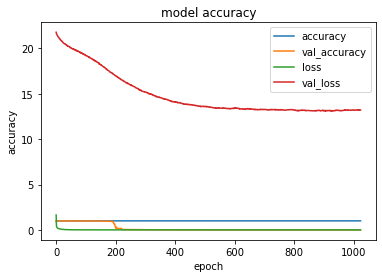

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [13]:
# 需要儲存article_id, 轉成dataframe
def predicting_txt_to_dataframe(path):    
    with open(path, 'r') as f:
        txt = str(f.read())
        txt_list = txt.split('\n')
    row_list = list()
    tmp_list = list()
    for row in txt_list:
        if row == '--------------------':
            tmp_list[0] = tmp_list[0].replace('article_id:', '')
            tmp_list[0] = int(tmp_list[0])
            row_list.append(tmp_list)
            tmp_list = list()
            continue
        if len(row) > 0:
            tmp_list.append(row)
    df = pd.DataFrame(row_list, columns=['article_id','text'])
    return df

In [14]:
def predict_NER(text):
    x_list = list()    
    text_list = re.split('\uff0c|\u3002|\uff1f', text)
    for article in text_list:
        x_list.append([i for i in article])
    y_list_list = model.predict(x_list)
    y_list = list()
    for sentence in y_list_list:
        for word in sentence:
            y_list.append(word)
        y_list.append('O') # append(，。？)
    y_list = y_list[:-1]
    return y_list

In [15]:
def output_NER(article_id, text, y_list):
    output_str = str()
    flag = False
    for i, j in enumerate(y_list):
        if j != 'O':
            if j[0] == 'B':
                start_position = i
                entity_type = j.split('-')[-1]
                flag = True
        elif j == 'O' and flag == True:
            end_position = i
            flag = False
            entity_text = text[start_position: end_position]
            entity = '{}\t{}\t{}\t{}\t{}\n'.format(article_id, start_position, end_position, entity_text, entity_type)  
            output_str += entity
    return output_str

In [16]:
df = predicting_txt_to_dataframe('/home/Danny/AI-CUP-2020/datasets/stage5/test.txt')
output_str = "article_id\tstart_position\tend_position\tentity_text\tentity_type\n"

for article_id, text in zip(df['article_id'], df['text']):
    x_list = [word for word in text]
    y_list = predict_NER(text)
    output_str += output_NER(article_id, text, y_list)

2020-12-15 08:10:02,437 [DEBUG] kashgari - predict seq_length: None, input: (2, 70, 17)


3/3 [==============================] - 0s 24ms/step


2020-12-15 08:10:06,302 [DEBUG] kashgari - predict output: (70, 17)
2020-12-15 08:10:06,303 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 0 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:10:06,306 [DEBUG] kashgari - predict seq_length: None, input: (2, 131, 28)


5/5 [==============================] - 0s 38ms/step


2020-12-15 08:10:10,248 [DEBUG] kashgari - predict output: (131, 28)
2020-12-15 08:10:10,249 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:10:10,253 [DEBUG] kashgari - predict seq_length: None, input: (2, 198, 47)


7/7 [==============================] - 0s 59ms/step


2020-12-15 08:10:14,443 [DEBUG] kashgari - predict output: (198, 47)
2020-12-15 08:10:14,444 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-15 08:10:14,448 [DEBUG] kashgari - predict seq_length: None, input: (2, 96, 41)


3/3 [==============================] - 0s 36ms/step


2020-12-15 08:10:17,193 [DEBUG] kashgari - predict output: (96, 41)
2020-12-15 08:10:17,194 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:10:17,196 [DEBUG] kashgari - predict seq_length: None, input: (2, 73, 17)


3/3 [==============================] - 0s 22ms/step


2020-12-15 08:10:17,326 [DEBUG] kashgari - predict output: (73, 17)
2020-12-15 08:10:17,327 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 9 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:10:17,332 [DEBUG] kashgari - predict seq_length: None, input: (2, 266, 23)


9/9 [==============================] - 0s 41ms/step


2020-12-15 08:10:21,463 [DEBUG] kashgari - predict output: (266, 23)
2020-12-15 08:10:21,464 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-15 08:10:21,470 [DEBUG] kashgari - predict seq_length: None, input: (2, 308, 21)


10/10 [==============================] - 0s 34ms/step


2020-12-15 08:10:26,222 [DEBUG] kashgari - predict output: (308, 21)
2020-12-15 08:10:26,223 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:10:26,226 [DEBUG] kashgari - predict seq_length: None, input: (2, 139, 38)


5/5 [==============================] - 0s 45ms/step


2020-12-15 08:10:30,233 [DEBUG] kashgari - predict output: (139, 38)
2020-12-15 08:10:30,234 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:10:30,237 [DEBUG] kashgari - predict seq_length: None, input: (2, 167, 22)


6/6 [==============================] - 0s 34ms/step


2020-12-15 08:10:34,182 [DEBUG] kashgari - predict output: (167, 22)
2020-12-15 08:10:34,183 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:10:34,189 [DEBUG] kashgari - predict seq_length: None, input: (2, 272, 41)


9/9 [==============================] - 0s 55ms/step


2020-12-15 08:10:38,476 [DEBUG] kashgari - predict output: (272, 41)
2020-12-15 08:10:38,476 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 7 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:10:38,479 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 63)


5/5 [==============================] - 0s 66ms/step


2020-12-15 08:10:42,579 [DEBUG] kashgari - predict output: (143, 63)
2020-12-15 08:10:42,579 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:10:42,586 [DEBUG] kashgari - predict seq_length: None, input: (2, 663, 42)


21/21 [==============================] - 1s 59ms/step


2020-12-15 08:10:47,576 [DEBUG] kashgari - predict output: (663, 42)
2020-12-15 08:10:47,577 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:10:47,579 [DEBUG] kashgari - predict seq_length: None, input: (2, 39, 25)


2/2 [==============================] - 0s 15ms/step


2020-12-15 08:10:51,344 [DEBUG] kashgari - predict output: (39, 25)
2020-12-15 08:10:51,347 [DEBUG] kashgari - predict output argmax: [[0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 0 1 1 1 

6/6 [==============================] - 0s 34ms/step


2020-12-15 08:10:51,629 [DEBUG] kashgari - predict output: (175, 22)
2020-12-15 08:10:51,630 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:10:51,634 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 28)


5/5 [==============================] - 0s 37ms/step


2020-12-15 08:10:51,894 [DEBUG] kashgari - predict output: (143, 28)
2020-12-15 08:10:51,895 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:10:51,898 [DEBUG] kashgari - predict seq_length: None, input: (2, 88, 21)


3/3 [==============================] - 0s 28ms/step


2020-12-15 08:10:52,050 [DEBUG] kashgari - predict output: (88, 21)
2020-12-15 08:10:52,051 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:10:52,055 [DEBUG] kashgari - predict seq_length: None, input: (2, 121, 28)


4/4 [==============================] - 0s 34ms/step


2020-12-15 08:10:52,268 [DEBUG] kashgari - predict output: (121, 28)
2020-12-15 08:10:52,269 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:10:52,272 [DEBUG] kashgari - predict seq_length: None, input: (2, 85, 27)


3/3 [==============================] - 0s 31ms/step


2020-12-15 08:10:57,346 [DEBUG] kashgari - predict output: (85, 27)
2020-12-15 08:10:57,347 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:10:57,352 [DEBUG] kashgari - predict seq_length: None, input: (2, 255, 19)


8/8 [==============================] - 0s 37ms/step


2020-12-15 08:11:01,473 [DEBUG] kashgari - predict output: (255, 19)
2020-12-15 08:11:01,474 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:01,479 [DEBUG] kashgari - predict seq_length: None, input: (2, 202, 29)


7/7 [==============================] - 0s 40ms/step


2020-12-15 08:11:05,526 [DEBUG] kashgari - predict output: (202, 29)
2020-12-15 08:11:05,527 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:05,530 [DEBUG] kashgari - predict seq_length: None, input: (2, 198, 19)


7/7 [==============================] - 0s 32ms/step


2020-12-15 08:11:05,820 [DEBUG] kashgari - predict output: (198, 19)
2020-12-15 08:11:05,821 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0 10  6 ...  6  6  6]
 [ 0  1  1 ...  6  6  6]
 [ 0  0  0 ...  0  0  0]]
2020-12-15 08:11:05,824 [DEBUG] kashgari - predict seq_length: None, input: (2, 102, 39)


4/4 [==============================] - 0s 43ms/step


2020-12-15 08:11:10,102 [DEBUG] kashgari - predict output: (102, 39)
2020-12-15 08:11:10,103 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:10,105 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 36)


3/3 [==============================] - 0s 32ms/step


2020-12-15 08:11:13,964 [DEBUG] kashgari - predict output: (72, 36)
2020-12-15 08:11:13,965 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:13,969 [DEBUG] kashgari - predict seq_length: None, input: (2, 246, 27)


8/8 [==============================] - 0s 42ms/step


2020-12-15 08:11:14,387 [DEBUG] kashgari - predict output: (246, 27)
2020-12-15 08:11:14,389 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:14,391 [DEBUG] kashgari - predict seq_length: None, input: (2, 57, 34)


2/2 [==============================] - 0s 27ms/step


2020-12-15 08:11:18,228 [DEBUG] kashgari - predict output: (57, 34)
2020-12-15 08:11:18,229 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:18,231 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 21)


3/3 [==============================] - 0s 28ms/step


2020-12-15 08:11:18,385 [DEBUG] kashgari - predict output: (82, 21)
2020-12-15 08:11:18,385 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:18,389 [DEBUG] kashgari - predict seq_length: None, input: (2, 185, 32)


6/6 [==============================] - 0s 42ms/step


2020-12-15 08:11:22,735 [DEBUG] kashgari - predict output: (185, 32)
2020-12-15 08:11:22,736 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:22,739 [DEBUG] kashgari - predict seq_length: None, input: (2, 148, 28)


5/5 [==============================] - 0s 32ms/step


2020-12-15 08:11:22,969 [DEBUG] kashgari - predict output: (148, 28)
2020-12-15 08:11:22,970 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:22,975 [DEBUG] kashgari - predict seq_length: None, input: (2, 281, 23)


9/9 [==============================] - 0s 36ms/step


2020-12-15 08:11:23,374 [DEBUG] kashgari - predict output: (281, 23)
2020-12-15 08:11:23,375 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:23,379 [DEBUG] kashgari - predict seq_length: None, input: (2, 116, 20)


4/4 [==============================] - 0s 29ms/step


2020-12-15 08:11:27,281 [DEBUG] kashgari - predict output: (116, 20)
2020-12-15 08:11:27,282 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:27,286 [DEBUG] kashgari - predict seq_length: None, input: (2, 168, 25)


6/6 [==============================] - 0s 38ms/step


2020-12-15 08:11:27,591 [DEBUG] kashgari - predict output: (168, 25)
2020-12-15 08:11:27,592 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 3 2 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:27,596 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 30)


7/7 [==============================] - 0s 43ms/step


2020-12-15 08:11:31,774 [DEBUG] kashgari - predict output: (218, 30)
2020-12-15 08:11:31,775 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:31,777 [DEBUG] kashgari - predict seq_length: None, input: (2, 123, 32)


4/4 [==============================] - 0s 36ms/step


2020-12-15 08:11:32,002 [DEBUG] kashgari - predict output: (123, 32)
2020-12-15 08:11:32,003 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:32,006 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 21)


3/3 [==============================] - 0s 23ms/step


2020-12-15 08:11:32,138 [DEBUG] kashgari - predict output: (82, 21)
2020-12-15 08:11:32,139 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 3 2 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:32,142 [DEBUG] kashgari - predict seq_length: None, input: (2, 95, 19)


3/3 [==============================] - 0s 25ms/step


2020-12-15 08:11:32,278 [DEBUG] kashgari - predict output: (95, 19)
2020-12-15 08:11:32,279 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 3 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:32,285 [DEBUG] kashgari - predict seq_length: None, input: (2, 245, 24)


8/8 [==============================] - 0s 39ms/step


2020-12-15 08:11:37,768 [DEBUG] kashgari - predict output: (245, 24)
2020-12-15 08:11:37,769 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 3 ... 5 5 5]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:37,772 [DEBUG] kashgari - predict seq_length: None, input: (2, 126, 31)


4/4 [==============================] - 0s 39ms/step


2020-12-15 08:11:41,728 [DEBUG] kashgari - predict output: (126, 31)
2020-12-15 08:11:41,729 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 7 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:41,731 [DEBUG] kashgari - predict seq_length: None, input: (2, 64, 19)


2/2 [==============================] - 0s 15ms/step


2020-12-15 08:11:44,399 [DEBUG] kashgari - predict output: (64, 19)
2020-12-15 08:11:44,400 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:44,403 [DEBUG] kashgari - predict seq_length: None, input: (2, 93, 24)


3/3 [==============================] - 0s 31ms/step


2020-12-15 08:11:44,567 [DEBUG] kashgari - predict output: (93, 24)
2020-12-15 08:11:44,568 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:44,572 [DEBUG] kashgari - predict seq_length: None, input: (2, 214, 16)


7/7 [==============================] - 0s 31ms/step


2020-12-15 08:11:48,601 [DEBUG] kashgari - predict output: (214, 16)
2020-12-15 08:11:48,602 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:48,604 [DEBUG] kashgari - predict seq_length: None, input: (2, 53, 20)


2/2 [==============================] - 0s 19ms/step


2020-12-15 08:11:48,712 [DEBUG] kashgari - predict output: (53, 20)
2020-12-15 08:11:48,712 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:48,718 [DEBUG] kashgari - predict seq_length: None, input: (2, 384, 18)


12/12 [==============================] - 0s 26ms/step


2020-12-15 08:11:51,693 [DEBUG] kashgari - predict output: (384, 18)
2020-12-15 08:11:51,694 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:51,697 [DEBUG] kashgari - predict seq_length: None, input: (2, 172, 24)


6/6 [==============================] - 0s 35ms/step


2020-12-15 08:11:51,978 [DEBUG] kashgari - predict output: (172, 24)
2020-12-15 08:11:51,979 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:51,982 [DEBUG] kashgari - predict seq_length: None, input: (2, 114, 24)


4/4 [==============================] - 0s 31ms/step


2020-12-15 08:11:52,175 [DEBUG] kashgari - predict output: (114, 24)
2020-12-15 08:11:52,176 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:52,179 [DEBUG] kashgari - predict seq_length: None, input: (2, 111, 47)


4/4 [==============================] - 0s 49ms/step


2020-12-15 08:11:52,473 [DEBUG] kashgari - predict output: (111, 47)
2020-12-15 08:11:52,474 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:52,479 [DEBUG] kashgari - predict seq_length: None, input: (2, 350, 34)


11/11 [==============================] - 1s 48ms/step


2020-12-15 08:11:53,091 [DEBUG] kashgari - predict output: (350, 34)
2020-12-15 08:11:53,092 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:53,094 [DEBUG] kashgari - predict seq_length: None, input: (2, 56, 20)


2/2 [==============================] - 0s 18ms/step


2020-12-15 08:11:53,190 [DEBUG] kashgari - predict output: (56, 20)
2020-12-15 08:11:53,191 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:53,194 [DEBUG] kashgari - predict seq_length: None, input: (2, 131, 17)


5/5 [==============================] - 0s 28ms/step


2020-12-15 08:11:53,393 [DEBUG] kashgari - predict output: (131, 17)
2020-12-15 08:11:53,394 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:53,399 [DEBUG] kashgari - predict seq_length: None, input: (2, 184, 34)


6/6 [==============================] - 0s 43ms/step


2020-12-15 08:11:53,740 [DEBUG] kashgari - predict output: (184, 34)
2020-12-15 08:11:53,741 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:53,743 [DEBUG] kashgari - predict seq_length: None, input: (2, 133, 51)


5/5 [==============================] - 0s 54ms/step


2020-12-15 08:11:57,800 [DEBUG] kashgari - predict output: (133, 51)
2020-12-15 08:11:57,801 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 9 5 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:11:57,805 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 53)


7/7 [==============================] - 0s 66ms/step


2020-12-15 08:12:02,031 [DEBUG] kashgari - predict output: (210, 53)
2020-12-15 08:12:02,032 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 5 5 5]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:02,035 [DEBUG] kashgari - predict seq_length: None, input: (2, 193, 55)


7/7 [==============================] - 0s 60ms/step


2020-12-15 08:12:06,229 [DEBUG] kashgari - predict output: (193, 55)
2020-12-15 08:12:06,229 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  9  5 ... 11 11 11]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-15 08:12:06,232 [DEBUG] kashgari - predict seq_length: None, input: (2, 75, 30)


3/3 [==============================] - 0s 27ms/step


2020-12-15 08:12:06,381 [DEBUG] kashgari - predict output: (75, 30)
2020-12-15 08:12:06,381 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:06,387 [DEBUG] kashgari - predict seq_length: None, input: (2, 280, 46)


9/9 [==============================] - 1s 62ms/step


2020-12-15 08:12:10,723 [DEBUG] kashgari - predict output: (280, 46)
2020-12-15 08:12:10,723 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:10,727 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 20)


7/7 [==============================] - 0s 32ms/step


2020-12-15 08:12:11,013 [DEBUG] kashgari - predict output: (210, 20)
2020-12-15 08:12:11,015 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:11,017 [DEBUG] kashgari - predict seq_length: None, input: (2, 176, 24)


6/6 [==============================] - 0s 34ms/step


2020-12-15 08:12:11,294 [DEBUG] kashgari - predict output: (176, 24)
2020-12-15 08:12:11,295 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:11,299 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 25)


7/7 [==============================] - 0s 38ms/step


2020-12-15 08:12:11,638 [DEBUG] kashgari - predict output: (218, 25)
2020-12-15 08:12:11,639 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:11,642 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 23)


3/3 [==============================] - 0s 28ms/step


2020-12-15 08:12:11,794 [DEBUG] kashgari - predict output: (91, 23)
2020-12-15 08:12:11,795 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:11,798 [DEBUG] kashgari - predict seq_length: None, input: (2, 194, 28)


7/7 [==============================] - 0s 38ms/step


2020-12-15 08:12:12,150 [DEBUG] kashgari - predict output: (194, 28)
2020-12-15 08:12:12,151 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 ...
 [0 3 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:12,156 [DEBUG] kashgari - predict seq_length: None, input: (2, 179, 23)


6/6 [==============================] - 0s 35ms/step


2020-12-15 08:12:12,433 [DEBUG] kashgari - predict output: (179, 23)
2020-12-15 08:12:12,434 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:12,439 [DEBUG] kashgari - predict seq_length: None, input: (2, 234, 40)


8/8 [==============================] - 0s 51ms/step


2020-12-15 08:12:16,650 [DEBUG] kashgari - predict output: (234, 40)
2020-12-15 08:12:16,651 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:16,655 [DEBUG] kashgari - predict seq_length: None, input: (2, 250, 26)


8/8 [==============================] - 0s 41ms/step


2020-12-15 08:12:21,172 [DEBUG] kashgari - predict output: (250, 26)
2020-12-15 08:12:21,173 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:21,177 [DEBUG] kashgari - predict seq_length: None, input: (2, 170, 43)


6/6 [==============================] - 0s 48ms/step


2020-12-15 08:12:26,643 [DEBUG] kashgari - predict output: (170, 43)
2020-12-15 08:12:26,644 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:26,647 [DEBUG] kashgari - predict seq_length: None, input: (2, 145, 34)


5/5 [==============================] - 0s 41ms/step


2020-12-15 08:12:26,929 [DEBUG] kashgari - predict output: (145, 34)
2020-12-15 08:12:26,930 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 3 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:26,932 [DEBUG] kashgari - predict seq_length: None, input: (2, 102, 29)


4/4 [==============================] - 0s 31ms/step


2020-12-15 08:12:27,131 [DEBUG] kashgari - predict output: (102, 29)
2020-12-15 08:12:27,132 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:27,138 [DEBUG] kashgari - predict seq_length: None, input: (2, 340, 20)


11/11 [==============================] - 0s 34ms/step


2020-12-15 08:12:27,580 [DEBUG] kashgari - predict output: (340, 20)
2020-12-15 08:12:27,581 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:27,584 [DEBUG] kashgari - predict seq_length: None, input: (2, 122, 23)


4/4 [==============================] - 0s 31ms/step


2020-12-15 08:12:27,778 [DEBUG] kashgari - predict output: (122, 23)
2020-12-15 08:12:27,779 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:27,790 [DEBUG] kashgari - predict seq_length: None, input: (2, 381, 28)


12/12 [==============================] - 1s 43ms/step


2020-12-15 08:12:28,391 [DEBUG] kashgari - predict output: (381, 28)
2020-12-15 08:12:28,392 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:28,396 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 27)


8/8 [==============================] - 0s 38ms/step


2020-12-15 08:12:28,775 [DEBUG] kashgari - predict output: (244, 27)
2020-12-15 08:12:28,777 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:28,779 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 46)


3/3 [==============================] - 0s 42ms/step


2020-12-15 08:12:29,001 [DEBUG] kashgari - predict output: (91, 46)
2020-12-15 08:12:29,002 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:29,006 [DEBUG] kashgari - predict seq_length: None, input: (2, 223, 42)


7/7 [==============================] - 0s 53ms/step


2020-12-15 08:12:29,467 [DEBUG] kashgari - predict output: (223, 42)
2020-12-15 08:12:29,468 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:29,470 [DEBUG] kashgari - predict seq_length: None, input: (2, 146, 25)


5/5 [==============================] - 0s 34ms/step


2020-12-15 08:12:29,712 [DEBUG] kashgari - predict output: (146, 25)
2020-12-15 08:12:29,713 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:29,717 [DEBUG] kashgari - predict seq_length: None, input: (2, 162, 23)


6/6 [==============================] - 0s 35ms/step


2020-12-15 08:12:29,995 [DEBUG] kashgari - predict output: (162, 23)
2020-12-15 08:12:29,996 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:30,001 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 27)


8/8 [==============================] - 0s 40ms/step


2020-12-15 08:12:30,394 [DEBUG] kashgari - predict output: (244, 27)
2020-12-15 08:12:30,395 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 9 5 ... 5 5 5]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:30,397 [DEBUG] kashgari - predict seq_length: None, input: (2, 170, 18)


6/6 [==============================] - 0s 33ms/step


2020-12-15 08:12:34,342 [DEBUG] kashgari - predict output: (170, 18)
2020-12-15 08:12:34,343 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 0 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:34,347 [DEBUG] kashgari - predict seq_length: None, input: (2, 199, 36)


7/7 [==============================] - 0s 47ms/step


2020-12-15 08:12:34,770 [DEBUG] kashgari - predict output: (199, 36)
2020-12-15 08:12:34,771 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:34,780 [DEBUG] kashgari - predict seq_length: None, input: (2, 557, 17)


18/18 [==============================] - 1s 34ms/step


2020-12-15 08:12:35,458 [DEBUG] kashgari - predict output: (557, 17)
2020-12-15 08:12:35,459 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 9 5 ... 5 5 5]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:35,463 [DEBUG] kashgari - predict seq_length: None, input: (2, 278, 42)


9/9 [==============================] - 0s 53ms/step


2020-12-15 08:12:36,033 [DEBUG] kashgari - predict output: (278, 42)
2020-12-15 08:12:36,034 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:36,039 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 19)


3/3 [==============================] - 0s 24ms/step


2020-12-15 08:12:36,176 [DEBUG] kashgari - predict output: (91, 19)
2020-12-15 08:12:36,177 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:36,183 [DEBUG] kashgari - predict seq_length: None, input: (2, 296, 24)


10/10 [==============================] - 0s 36ms/step


2020-12-15 08:12:36,618 [DEBUG] kashgari - predict output: (296, 24)
2020-12-15 08:12:36,620 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:36,623 [DEBUG] kashgari - predict seq_length: None, input: (2, 154, 48)


5/5 [==============================] - 0s 55ms/step


2020-12-15 08:12:40,741 [DEBUG] kashgari - predict output: (154, 48)
2020-12-15 08:12:40,742 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:40,745 [DEBUG] kashgari - predict seq_length: None, input: (2, 206, 37)


7/7 [==============================] - 0s 49ms/step


2020-12-15 08:12:45,008 [DEBUG] kashgari - predict output: (206, 37)
2020-12-15 08:12:45,009 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 9 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:45,012 [DEBUG] kashgari - predict seq_length: None, input: (2, 241, 20)


8/8 [==============================] - 0s 32ms/step


2020-12-15 08:12:45,333 [DEBUG] kashgari - predict output: (241, 20)
2020-12-15 08:12:45,335 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:45,340 [DEBUG] kashgari - predict seq_length: None, input: (2, 459, 31)


15/15 [==============================] - 1s 46ms/step


2020-12-15 08:12:46,120 [DEBUG] kashgari - predict output: (459, 31)
2020-12-15 08:12:46,121 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:46,125 [DEBUG] kashgari - predict seq_length: None, input: (2, 223, 34)


7/7 [==============================] - 0s 46ms/step


2020-12-15 08:12:46,529 [DEBUG] kashgari - predict output: (223, 34)
2020-12-15 08:12:46,530 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:46,535 [DEBUG] kashgari - predict seq_length: None, input: (2, 358, 26)


12/12 [==============================] - 0s 41ms/step


2020-12-15 08:12:47,097 [DEBUG] kashgari - predict output: (358, 26)
2020-12-15 08:12:47,098 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:47,102 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 20)


3/3 [==============================] - 0s 23ms/step


2020-12-15 08:12:47,237 [DEBUG] kashgari - predict output: (72, 20)
2020-12-15 08:12:47,238 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:47,241 [DEBUG] kashgari - predict seq_length: None, input: (2, 75, 24)


3/3 [==============================] - 0s 25ms/step


2020-12-15 08:12:47,385 [DEBUG] kashgari - predict output: (75, 24)
2020-12-15 08:12:47,386 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:47,390 [DEBUG] kashgari - predict seq_length: None, input: (2, 191, 36)


6/6 [==============================] - 0s 45ms/step


2020-12-15 08:12:47,740 [DEBUG] kashgari - predict output: (191, 36)
2020-12-15 08:12:47,741 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:47,745 [DEBUG] kashgari - predict seq_length: None, input: (2, 149, 19)


5/5 [==============================] - 0s 30ms/step


2020-12-15 08:12:47,956 [DEBUG] kashgari - predict output: (149, 19)
2020-12-15 08:12:47,957 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:47,961 [DEBUG] kashgari - predict seq_length: None, input: (2, 176, 22)


6/6 [==============================] - 0s 32ms/step


2020-12-15 08:12:48,217 [DEBUG] kashgari - predict output: (176, 22)
2020-12-15 08:12:48,218 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0 17 11 ... 11 11 11]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-15 08:12:48,221 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 45)


4/4 [==============================] - 0s 51ms/step


2020-12-15 08:12:52,248 [DEBUG] kashgari - predict output: (112, 45)
2020-12-15 08:12:52,249 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:52,252 [DEBUG] kashgari - predict seq_length: None, input: (2, 269, 21)


9/9 [==============================] - 0s 33ms/step


2020-12-15 08:12:52,623 [DEBUG] kashgari - predict output: (269, 21)
2020-12-15 08:12:52,624 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:52,628 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 18)


4/4 [==============================] - 0s 24ms/step


2020-12-15 08:12:52,782 [DEBUG] kashgari - predict output: (112, 18)
2020-12-15 08:12:52,783 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 7 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:52,789 [DEBUG] kashgari - predict seq_length: None, input: (2, 352, 22)


11/11 [==============================] - 0s 30ms/step


2020-12-15 08:12:55,741 [DEBUG] kashgari - predict output: (352, 22)
2020-12-15 08:12:55,742 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:55,745 [DEBUG] kashgari - predict seq_length: None, input: (2, 243, 24)


8/8 [==============================] - 0s 35ms/step


2020-12-15 08:12:56,098 [DEBUG] kashgari - predict output: (243, 24)
2020-12-15 08:12:56,099 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:56,106 [DEBUG] kashgari - predict seq_length: None, input: (2, 340, 27)


11/11 [==============================] - 0s 42ms/step


2020-12-15 08:12:56,643 [DEBUG] kashgari - predict output: (340, 27)
2020-12-15 08:12:56,644 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:56,650 [DEBUG] kashgari - predict seq_length: None, input: (2, 384, 25)


12/12 [==============================] - 0s 33ms/step


2020-12-15 08:12:59,692 [DEBUG] kashgari - predict output: (384, 25)
2020-12-15 08:12:59,693 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:59,696 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 36)


4/4 [==============================] - 0s 39ms/step


2020-12-15 08:12:59,934 [DEBUG] kashgari - predict output: (112, 36)
2020-12-15 08:12:59,935 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:12:59,939 [DEBUG] kashgari - predict seq_length: None, input: (2, 222, 28)


7/7 [==============================] - 0s 41ms/step


2020-12-15 08:13:00,304 [DEBUG] kashgari - predict output: (222, 28)
2020-12-15 08:13:00,304 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:00,308 [DEBUG] kashgari - predict seq_length: None, input: (2, 255, 34)


8/8 [==============================] - 0s 47ms/step


2020-12-15 08:13:00,761 [DEBUG] kashgari - predict output: (255, 34)
2020-12-15 08:13:00,762 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:00,764 [DEBUG] kashgari - predict seq_length: None, input: (2, 67, 25)


3/3 [==============================] - 0s 25ms/step


2020-12-15 08:13:00,907 [DEBUG] kashgari - predict output: (67, 25)
2020-12-15 08:13:00,908 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:00,910 [DEBUG] kashgari - predict seq_length: None, input: (2, 77, 53)


3/3 [==============================] - 0s 44ms/step


2020-12-15 08:13:01,143 [DEBUG] kashgari - predict output: (77, 53)
2020-12-15 08:13:01,144 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:01,146 [DEBUG] kashgari - predict seq_length: None, input: (2, 67, 27)


3/3 [==============================] - 0s 27ms/step


2020-12-15 08:13:01,299 [DEBUG] kashgari - predict output: (67, 27)
2020-12-15 08:13:01,300 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ... 11 11 11]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-15 08:13:01,303 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 19)


3/3 [==============================] - 0s 24ms/step


2020-12-15 08:13:01,437 [DEBUG] kashgari - predict output: (72, 19)
2020-12-15 08:13:01,438 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:01,441 [DEBUG] kashgari - predict seq_length: None, input: (2, 98, 24)


4/4 [==============================] - 0s 29ms/step


2020-12-15 08:13:01,626 [DEBUG] kashgari - predict output: (98, 24)
2020-12-15 08:13:01,627 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:01,629 [DEBUG] kashgari - predict seq_length: None, input: (2, 87, 37)


3/3 [==============================] - 0s 37ms/step


2020-12-15 08:13:01,821 [DEBUG] kashgari - predict output: (87, 37)
2020-12-15 08:13:01,822 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:01,828 [DEBUG] kashgari - predict seq_length: None, input: (2, 311, 29)


10/10 [==============================] - 0s 43ms/step


2020-12-15 08:13:02,341 [DEBUG] kashgari - predict output: (311, 29)
2020-12-15 08:13:02,342 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:02,350 [DEBUG] kashgari - predict seq_length: None, input: (2, 447, 20)


14/14 [==============================] - 0s 35ms/step


2020-12-15 08:13:02,903 [DEBUG] kashgari - predict output: (447, 20)
2020-12-15 08:13:02,904 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:02,907 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 19)


7/7 [==============================] - 0s 33ms/step


2020-12-15 08:13:03,201 [DEBUG] kashgari - predict output: (218, 19)
2020-12-15 08:13:03,202 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:03,208 [DEBUG] kashgari - predict seq_length: None, input: (2, 285, 30)


9/9 [==============================] - 0s 43ms/step


2020-12-15 08:13:03,677 [DEBUG] kashgari - predict output: (285, 30)
2020-12-15 08:13:03,679 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 4]
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:03,685 [DEBUG] kashgari - predict seq_length: None, input: (2, 424, 21)


14/14 [==============================] - 1s 36ms/step


2020-12-15 08:13:04,257 [DEBUG] kashgari - predict output: (424, 21)
2020-12-15 08:13:04,259 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:04,261 [DEBUG] kashgari - predict seq_length: None, input: (2, 94, 30)


3/3 [==============================] - 0s 31ms/step


2020-12-15 08:13:04,429 [DEBUG] kashgari - predict output: (94, 30)
2020-12-15 08:13:04,430 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:04,434 [DEBUG] kashgari - predict seq_length: None, input: (2, 202, 34)


7/7 [==============================] - 0s 43ms/step


2020-12-15 08:13:04,812 [DEBUG] kashgari - predict output: (202, 34)
2020-12-15 08:13:04,813 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:04,819 [DEBUG] kashgari - predict seq_length: None, input: (2, 242, 50)


8/8 [==============================] - 1s 64ms/step


2020-12-15 08:13:09,172 [DEBUG] kashgari - predict output: (242, 50)
2020-12-15 08:13:09,173 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-15 08:13:09,177 [DEBUG] kashgari - predict seq_length: None, input: (2, 269, 38)


9/9 [==============================] - 0s 50ms/step


2020-12-15 08:13:09,713 [DEBUG] kashgari - predict output: (269, 38)
2020-12-15 08:13:09,714 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:09,718 [DEBUG] kashgari - predict seq_length: None, input: (2, 108, 35)


4/4 [==============================] - 0s 40ms/step


2020-12-15 08:13:13,692 [DEBUG] kashgari - predict output: (108, 35)
2020-12-15 08:13:13,693 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:13,696 [DEBUG] kashgari - predict seq_length: None, input: (2, 136, 30)


5/5 [==============================] - 0s 40ms/step


2020-12-15 08:13:13,976 [DEBUG] kashgari - predict output: (136, 30)
2020-12-15 08:13:13,977 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:13,981 [DEBUG] kashgari - predict seq_length: None, input: (2, 217, 28)


7/7 [==============================] - 0s 43ms/step


2020-12-15 08:13:14,360 [DEBUG] kashgari - predict output: (217, 28)
2020-12-15 08:13:14,361 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:14,363 [DEBUG] kashgari - predict seq_length: None, input: (2, 83, 27)


3/3 [==============================] - 0s 29ms/step


2020-12-15 08:13:14,521 [DEBUG] kashgari - predict output: (83, 27)
2020-12-15 08:13:14,522 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:14,528 [DEBUG] kashgari - predict seq_length: None, input: (2, 392, 36)


13/13 [==============================] - 1s 50ms/step


2020-12-15 08:13:15,269 [DEBUG] kashgari - predict output: (392, 36)
2020-12-15 08:13:15,270 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:15,273 [DEBUG] kashgari - predict seq_length: None, input: (2, 108, 41)


4/4 [==============================] - 0s 42ms/step


2020-12-15 08:13:15,526 [DEBUG] kashgari - predict output: (108, 41)
2020-12-15 08:13:15,527 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:15,531 [DEBUG] kashgari - predict seq_length: None, input: (2, 221, 26)


7/7 [==============================] - 0s 38ms/step


2020-12-15 08:13:15,870 [DEBUG] kashgari - predict output: (221, 26)
2020-12-15 08:13:15,871 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:15,875 [DEBUG] kashgari - predict seq_length: None, input: (2, 94, 45)


3/3 [==============================] - 0s 46ms/step


2020-12-15 08:13:16,111 [DEBUG] kashgari - predict output: (94, 45)
2020-12-15 08:13:16,112 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:16,114 [DEBUG] kashgari - predict seq_length: None, input: (2, 59, 21)


2/2 [==============================] - 0s 19ms/step


2020-12-15 08:13:16,223 [DEBUG] kashgari - predict output: (59, 21)
2020-12-15 08:13:16,224 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:16,226 [DEBUG] kashgari - predict seq_length: None, input: (2, 101, 33)


4/4 [==============================] - 0s 38ms/step


2020-12-15 08:13:20,126 [DEBUG] kashgari - predict output: (101, 33)
2020-12-15 08:13:20,127 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:20,129 [DEBUG] kashgari - predict seq_length: None, input: (2, 64, 33)


2/2 [==============================] - 0s 23ms/step


2020-12-15 08:13:22,826 [DEBUG] kashgari - predict output: (64, 33)
2020-12-15 08:13:22,827 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:22,829 [DEBUG] kashgari - predict seq_length: None, input: (2, 85, 30)


3/3 [==============================] - 0s 33ms/step


2020-12-15 08:13:23,007 [DEBUG] kashgari - predict output: (85, 30)
2020-12-15 08:13:23,008 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:23,010 [DEBUG] kashgari - predict seq_length: None, input: (2, 89, 33)


3/3 [==============================] - 0s 34ms/step


2020-12-15 08:13:23,202 [DEBUG] kashgari - predict output: (89, 33)
2020-12-15 08:13:23,203 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:23,207 [DEBUG] kashgari - predict seq_length: None, input: (2, 254, 27)


8/8 [==============================] - 0s 40ms/step


2020-12-15 08:13:23,605 [DEBUG] kashgari - predict output: (254, 27)
2020-12-15 08:13:23,605 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:23,608 [DEBUG] kashgari - predict seq_length: None, input: (2, 129, 29)


5/5 [==============================] - 0s 35ms/step


2020-12-15 08:13:23,855 [DEBUG] kashgari - predict output: (129, 29)
2020-12-15 08:13:23,856 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:23,859 [DEBUG] kashgari - predict seq_length: None, input: (2, 130, 26)


5/5 [==============================] - 0s 34ms/step


2020-12-15 08:13:24,111 [DEBUG] kashgari - predict output: (130, 26)
2020-12-15 08:13:24,112 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:24,116 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 37)


5/5 [==============================] - 0s 43ms/step


2020-12-15 08:13:24,418 [DEBUG] kashgari - predict output: (143, 37)
2020-12-15 08:13:24,419 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:24,421 [DEBUG] kashgari - predict seq_length: None, input: (2, 107, 36)


4/4 [==============================] - 0s 37ms/step


2020-12-15 08:13:24,652 [DEBUG] kashgari - predict output: (107, 36)
2020-12-15 08:13:24,652 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:24,655 [DEBUG] kashgari - predict seq_length: None, input: (2, 70, 28)


3/3 [==============================] - 0s 26ms/step


2020-12-15 08:13:24,802 [DEBUG] kashgari - predict output: (70, 28)
2020-12-15 08:13:24,802 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:24,807 [DEBUG] kashgari - predict seq_length: None, input: (2, 189, 26)


6/6 [==============================] - 0s 37ms/step


2020-12-15 08:13:25,101 [DEBUG] kashgari - predict output: (189, 26)
2020-12-15 08:13:25,102 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:25,106 [DEBUG] kashgari - predict seq_length: None, input: (2, 99, 48)


4/4 [==============================] - 0s 45ms/step


2020-12-15 08:13:25,391 [DEBUG] kashgari - predict output: (99, 48)
2020-12-15 08:13:25,392 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:25,396 [DEBUG] kashgari - predict seq_length: None, input: (2, 213, 35)


7/7 [==============================] - 0s 45ms/step


2020-12-15 08:13:25,799 [DEBUG] kashgari - predict output: (213, 35)
2020-12-15 08:13:25,800 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:25,803 [DEBUG] kashgari - predict seq_length: None, input: (2, 181, 40)


6/6 [==============================] - 0s 48ms/step


2020-12-15 08:13:26,174 [DEBUG] kashgari - predict output: (181, 40)
2020-12-15 08:13:26,175 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:26,178 [DEBUG] kashgari - predict seq_length: None, input: (2, 119, 34)


4/4 [==============================] - 0s 38ms/step


2020-12-15 08:13:26,410 [DEBUG] kashgari - predict output: (119, 34)
2020-12-15 08:13:26,411 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:26,414 [DEBUG] kashgari - predict seq_length: None, input: (2, 188, 52)


6/6 [==============================] - 0s 65ms/step


2020-12-15 08:13:30,677 [DEBUG] kashgari - predict output: (188, 52)
2020-12-15 08:13:30,678 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:30,682 [DEBUG] kashgari - predict seq_length: None, input: (2, 252, 30)


8/8 [==============================] - 0s 43ms/step


2020-12-15 08:13:31,102 [DEBUG] kashgari - predict output: (252, 30)
2020-12-15 08:13:31,103 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:31,108 [DEBUG] kashgari - predict seq_length: None, input: (2, 249, 38)


8/8 [==============================] - 0s 50ms/step


2020-12-15 08:13:31,594 [DEBUG] kashgari - predict output: (249, 38)
2020-12-15 08:13:31,595 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 3 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:31,598 [DEBUG] kashgari - predict seq_length: None, input: (2, 65, 44)


3/3 [==============================] - 0s 35ms/step


2020-12-15 08:13:35,866 [DEBUG] kashgari - predict output: (65, 44)
2020-12-15 08:13:35,867 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:35,871 [DEBUG] kashgari - predict seq_length: None, input: (2, 265, 41)


9/9 [==============================] - 0s 54ms/step


2020-12-15 08:13:36,459 [DEBUG] kashgari - predict output: (265, 41)
2020-12-15 08:13:36,460 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:36,464 [DEBUG] kashgari - predict seq_length: None, input: (2, 163, 33)


6/6 [==============================] - 0s 41ms/step


2020-12-15 08:13:36,796 [DEBUG] kashgari - predict output: (163, 33)
2020-12-15 08:13:36,797 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 2 2 2]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:36,800 [DEBUG] kashgari - predict seq_length: None, input: (2, 166, 33)


6/6 [==============================] - 0s 42ms/step


2020-12-15 08:13:37,130 [DEBUG] kashgari - predict output: (166, 33)
2020-12-15 08:13:37,131 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 7 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:37,136 [DEBUG] kashgari - predict seq_length: None, input: (2, 152, 37)


5/5 [==============================] - 0s 45ms/step


2020-12-15 08:13:37,446 [DEBUG] kashgari - predict output: (152, 37)
2020-12-15 08:13:37,447 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:37,450 [DEBUG] kashgari - predict seq_length: None, input: (2, 129, 26)


5/5 [==============================] - 0s 33ms/step


2020-12-15 08:13:37,685 [DEBUG] kashgari - predict output: (129, 26)
2020-12-15 08:13:37,686 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:37,690 [DEBUG] kashgari - predict seq_length: None, input: (2, 260, 42)


9/9 [==============================] - 0s 53ms/step


2020-12-15 08:13:38,256 [DEBUG] kashgari - predict output: (260, 42)
2020-12-15 08:13:38,257 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:38,266 [DEBUG] kashgari - predict seq_length: None, input: (2, 557, 59)


18/18 [==============================] - 1s 78ms/step


2020-12-15 08:13:45,312 [DEBUG] kashgari - predict output: (557, 59)
2020-12-15 08:13:45,313 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:45,318 [DEBUG] kashgari - predict seq_length: None, input: (2, 144, 72)


5/5 [==============================] - 0s 74ms/step


2020-12-15 08:13:49,497 [DEBUG] kashgari - predict output: (144, 72)
2020-12-15 08:13:49,498 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:49,504 [DEBUG] kashgari - predict seq_length: None, input: (2, 474, 27)


15/15 [==============================] - 1s 43ms/step


2020-12-15 08:13:50,219 [DEBUG] kashgari - predict output: (474, 27)
2020-12-15 08:13:50,220 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:50,224 [DEBUG] kashgari - predict seq_length: None, input: (2, 253, 34)


8/8 [==============================] - 0s 47ms/step


2020-12-15 08:13:50,686 [DEBUG] kashgari - predict output: (253, 34)
2020-12-15 08:13:50,687 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:50,691 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 45)


7/7 [==============================] - 0s 57ms/step


2020-12-15 08:13:51,192 [DEBUG] kashgari - predict output: (210, 45)
2020-12-15 08:13:51,193 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:51,197 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 32)


8/8 [==============================] - 0s 43ms/step


2020-12-15 08:13:51,618 [DEBUG] kashgari - predict output: (244, 32)
2020-12-15 08:13:51,619 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:51,623 [DEBUG] kashgari - predict seq_length: None, input: (2, 319, 36)


10/10 [==============================] - 1s 50ms/step


2020-12-15 08:13:52,213 [DEBUG] kashgari - predict output: (319, 36)
2020-12-15 08:13:52,214 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:52,220 [DEBUG] kashgari - predict seq_length: None, input: (2, 437, 36)


14/14 [==============================] - 1s 51ms/step


2020-12-15 08:13:53,029 [DEBUG] kashgari - predict output: (437, 36)
2020-12-15 08:13:53,030 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 08:13:53,033 [DEBUG] kashgari - predict seq_length: None, input: (2, 171, 78)


6/6 [==============================] - 0s 83ms/step


2020-12-15 08:13:57,630 [DEBUG] kashgari - predict output: (171, 78)
2020-12-15 08:13:57,630 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]


In [17]:
# print(output_str)

In [18]:
output_path = 'output/{}_epoch_{}_batch_{}.tsv'.format(model_name, epochs, batch_size)
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(output_str)